<a href="https://colab.research.google.com/github/mohammad-rahbari/Federated-Learning-MLDL/blob/master/notebooks/MLDL_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import pandas as pd
import numpy as np

# Extract trained setting

In [3]:

def get_seed_models(df):
  filter = df['round_number'] == 0
  df_filtered = df[filter]
  return df_filtered

def get_model_squence(df, seed_model):
  result = df[df['model_name']==seed_model['model_name']]
  latest_model = result['model_name'].values[0]
  while True:
    if latest_model in df['prev_global_model_name'].values:
      temp =  df[df['prev_global_model_name']==latest_model]
      latest_model = temp['model_name'].values[0]
      result = pd.concat([result, temp])
    else:
      break
  result = result.sort_values(by=['round_number'])
  return result

def get_from_client(df_client, model_name, attribute, single_record= True):
  if single_record:
    return df_client[df_client['initial_model_name']==model_name][attribute].values[0]
  else:
    return df_client[df_client['initial_model_name']==model_name][attribute]

def get_vlid_lst(lst):
  result = []
  for i in lst:

    if not (i is None or np.isnan(i)):
      result.append(i)

  return result

In [ ]:
df_global = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/global_log.csv")
df_client = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/client_log.csv")

seed_models = get_seed_models(df_global)
for i in range(len(seed_models)):

  log = f"{i+1})\n"


  df_seq = get_model_squence(df_global,seed_models.iloc[i] )
  r_num = max(get_vlid_lst(df_seq['round_number'].values))
  if r_num != 0:

    log +=f"Seed model: {seed_models.iloc[i]['model_name']} \n"
    log +=f"Spliting method: {df_seq['splitting_method'].values[-1]}  \n"
    if df_seq['splitting_method'].values[-1] == "non-i.i.d. sharing":
      log +=f"Nc: {max(get_vlid_lst(df_seq['Nc'].values))}  \n"
    log +=f"Number of rounds: {r_num}  \n"
    log +=f"Number of local_steps: {max(get_vlid_lst(df_seq['num_local_steps'].values))}  \n"
    try:
      log +=f"Target Sparcity: {get_from_client(df_client, seed_models.iloc[i]['model_name'], 'sparsity')}  \n"
    except:
      f"Target Sparcity: {0.5}  \n"
      pass
    log +=f"Accuracy: {df_seq[df_seq['round_number']== r_num]['accuracy'].values[-1]}  \n"
    log +=f"Loss: {df_seq[df_seq['round_number']== r_num]['loss'].values[-1]} \n"


    print(log," \n \n \n")







In [61]:
df_global = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/global_log.csv")

model_name_to_update = "ba641ff5-2a41-49f9-bd49-07b0a9a595a3"
new_nc_value = 100
new_local_step_num_value = 8

# Update 'Nc' and 'num_local_steps' for the specified model name
df_global.loc[df_global['model_name'] == model_name_to_update, 'Nc'] = new_nc_value
df_global.loc[df_global['model_name'] == model_name_to_update, 'num_local_steps'] = new_local_step_num_value

# Display the updated rows to verify
display(df_global[df_global['model_name'] == model_name_to_update])

,backbone,num_of_clients,splitting_method,Nc,num_local_steps,aggregation_method,Measurement_criteria,accuracy,loss,size_of_dataset,...,round_number,num_of_participants,model_name,prev_global_model_name,contributors,path,momentum_vector_path,path_to_subsets,path_to_class_combs,time
654,dino_vits16,100,i.i.d. sharing,100.0,8.0,FedAvg,"accuracy,loss",47.13,2.006864,50000,...,50,10.0,ba641ff5-2a41-49f9-bd49-07b0a9a595a3,664e5fb4-d72f-437c-87e8-081869edb33a,"['7a3b3c3a-9bf2-4a06-aee6-4a0de9e7095d', '0f94...",/content/drive/MyDrive/MLDL_FederatedLearning/...,NaN,/content/drive/MyDrive/MLDL_FederatedLearning/...,NaN,2025-09-06 21:11:39


In [62]:
df_global.to_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/global_log.csv", index=False)

In [64]:
modename_targetround= {
    "3b16bcde-abf5-4c87-b9bb-ef2827a59c6d":25,
    "1f7efd38-b55a-458c-9478-b763895e5acc":25,
    "165b689b-6b5e-48eb-9d24-ae343a039013":25,
    "0af55aa3-0139-49aa-95c4-854a511ad30d":25,
    "3fba6992-552f-420f-877f-82afd3f0ef6f":50,
    "f77e86b0-b0e3-4cd8-b65a-40323e81b49b":50,
    "fdb2734f-a092-4641-a843-969dcc993937":100,
    "91be5aaa-6416-4558-89d4-a8c18e6d1e2f":50,
    "0decec9d-3280-48d6-8c4e-ad1785b9736e":50,
    "f60e06e4-ac4b-4495-8904-16753c21c425":25,
    "453429aa-5c7f-4046-b4f2-658588fc9c38":25,
    "201a5aeb-0d1e-438f-8178-4ebcc4d94435":50,
    "23f056c6-52e9-47b2-beb1-9ef590f743cc":100,
    "61cb31ef-74c1-4f60-95e9-d35fd60a7d55":100,
    "f56d4e15-9536-4733-9120-6423230a650d":100,
    "f142f936-1ed1-4dfb-b0b2-3f99aff46a89":100,
    "612d19a1-3b97-466f-a17f-892ce36bd5c9":25
    }
data_for_new_df = []

df_global = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/global_log.csv")
df_client = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/client_log.csv")



seed_models = get_seed_models(df_global)
for i in range(len(seed_models)):
  df_seq = get_model_squence(df_global,seed_models.iloc[i] )
  seed_name = seed_models.iloc[i]['model_name']
  if seed_name not in modename_targetround.keys():
    continue
  record = df_seq[df_seq["round_number"]==modename_targetround[seed_name]]
  sparsity =  get_from_client(df_client, seed_models.iloc[i]['model_name'], 'sparsity') if seed_name != "612d19a1-3b97-466f-a17f-892ce36bd5c9" else 0.5

  splitting_method =  record['splitting_method'].values[0]
  splitting_method =splitting_method.replace(" sharing", "")

  data_for_new_df.append({

        'round_number': record['round_number'].values[0],
        'local_step': int(record['num_local_steps'].values[-1]),
        'sparsity': sparsity,
        'Nc': int(record['Nc'].values[-1]),
        'accuracy': record['accuracy'].values[0],
        'loss': record['loss'].values[0],
        'aggregation_method' : record["aggregation_method"].values[0],
        'spliting_method':splitting_method,
        'seed_model_name': seed_name,
        'last_model_name': record["model_name"].values[0]

    })


result_df = pd.DataFrame(data_for_new_df)


display(result_df)

,round_number,local_step,sparsity,Nc,accuracy,loss,aggregation_method,spliting_method,seed_model_name,last_model_name
0,100,4,0.5,100,37.55,2.509509,FedAvg,i.i.d.,f142f936-1ed1-4dfb-b0b2-3f99aff46a89,900f32b7-9a03-4eaf-b252-feaa8944678d
1,100,4,0.5,50,42.89,2.220242,FedAvg,non-i.i.d.,f56d4e15-9536-4733-9120-6423230a650d,6f243790-ba8b-4bf0-8fdc-15ca06b78067
2,100,4,0.5,10,42.20,2.311263,FedAvg,non-i.i.d.,61cb31ef-74c1-4f60-95e9-d35fd60a7d55,d061c76f-18ab-4e8b-b2df-7392c9cdb8c6
3,100,4,0.5,5,36.99,2.483904,FedAvg,non-i.i.d.,23f056c6-52e9-47b2-beb1-9ef590f743cc,766ea6e6-f387-4939-b06f-a92141f40947
4,50,8,0.5,100,47.13,2.006864,FedAvg,i.i.d.,201a5aeb-0d1e-438f-8178-4ebcc4d94435,ba641ff5-2a41-49f9-bd49-07b0a9a595a3
5,25,16,0.5,100,54.13,1.704356,FedAvg,i.i.d.,612d19a1-3b97-466f-a17f-892ce36bd5c9,96e69034-1f33-4cb4-af98-5fedc9223e2d
6,25,16,0.5,50,55.72,1.633388,FedAvg,non-i.i.d.,453429aa-5c7f-4046-b4f2-658588fc9c38,afda943f-f16c-432a-ac3f-049d507f9ba3
7,25,16,0.5,1,9.38,6.838218,FedAvg,non-i.i.d.,f60e06e4-ac4b-4495-8904-16753c21c425,81667e00-23ee-4ff7-965d-2965bd0fb750
8,50,8,0.5,50,51.73,1.817291,FedAvg,non-i.i.d.,0decec9d-3280-48d6-8c4e-ad1785b9736e,94781c1d-c50e-4ec9-afd2-358a0f6850c6
9,50,8,0.5,10,45.61,2.107623,FedAvg,non-i.i.d.,91be5aaa-6416-4558-89d4-a8c18e6d1e2f,f48789e6-5511-4885-b57f-563bccb93d2b


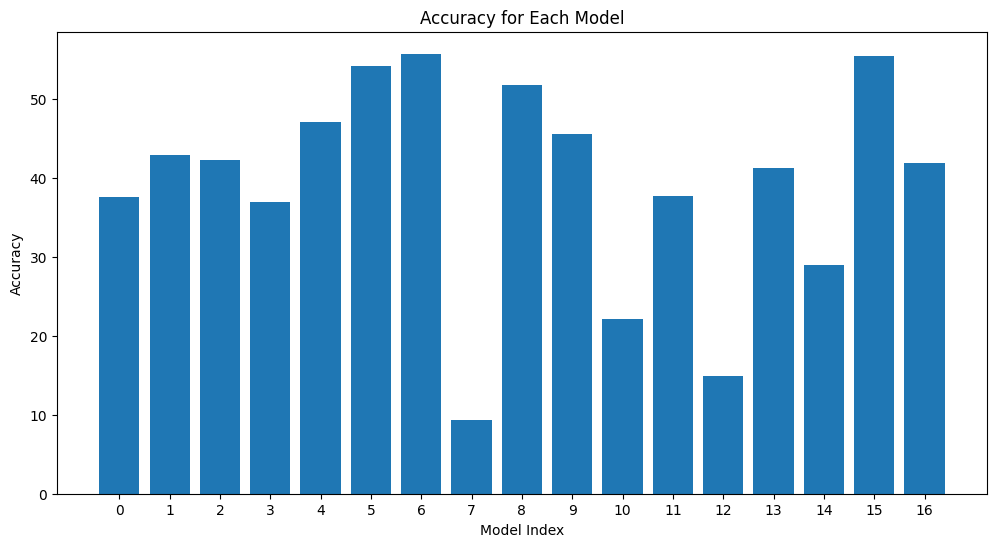

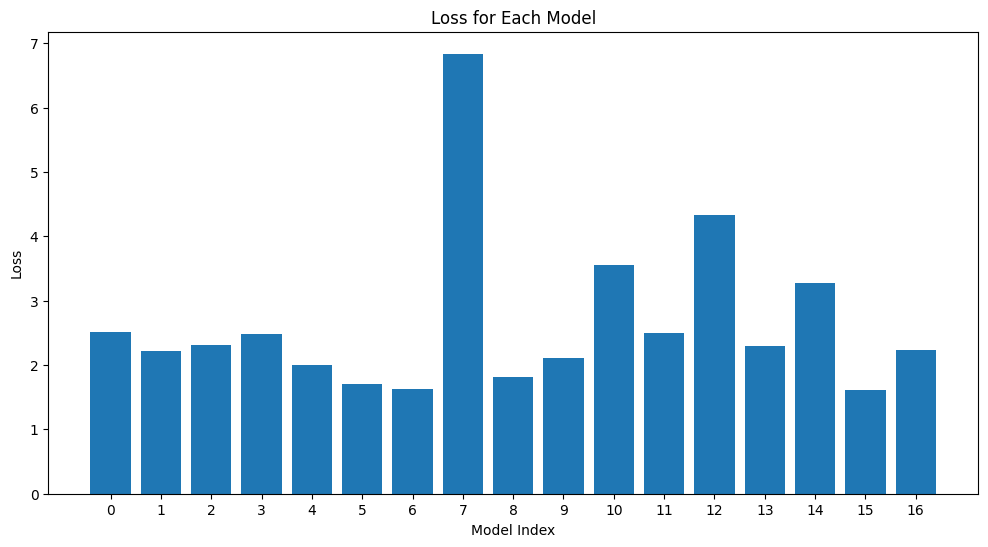

In [65]:
import matplotlib.pyplot as plt

# Create a bar chart for accuracy
plt.figure(figsize=(12, 6))
plt.bar(result_df.index, result_df['accuracy'])
plt.xlabel('Model Index')
plt.ylabel('Accuracy')
plt.title('Accuracy for Each Model')
plt.xticks(result_df.index)
plt.show()

# Create a bar chart for loss
plt.figure(figsize=(12, 6))
plt.bar(result_df.index, result_df['loss'])
plt.xlabel('Model Index')
plt.ylabel('Loss')
plt.title('Loss for Each Model')
plt.xticks(result_df.index)
plt.show()

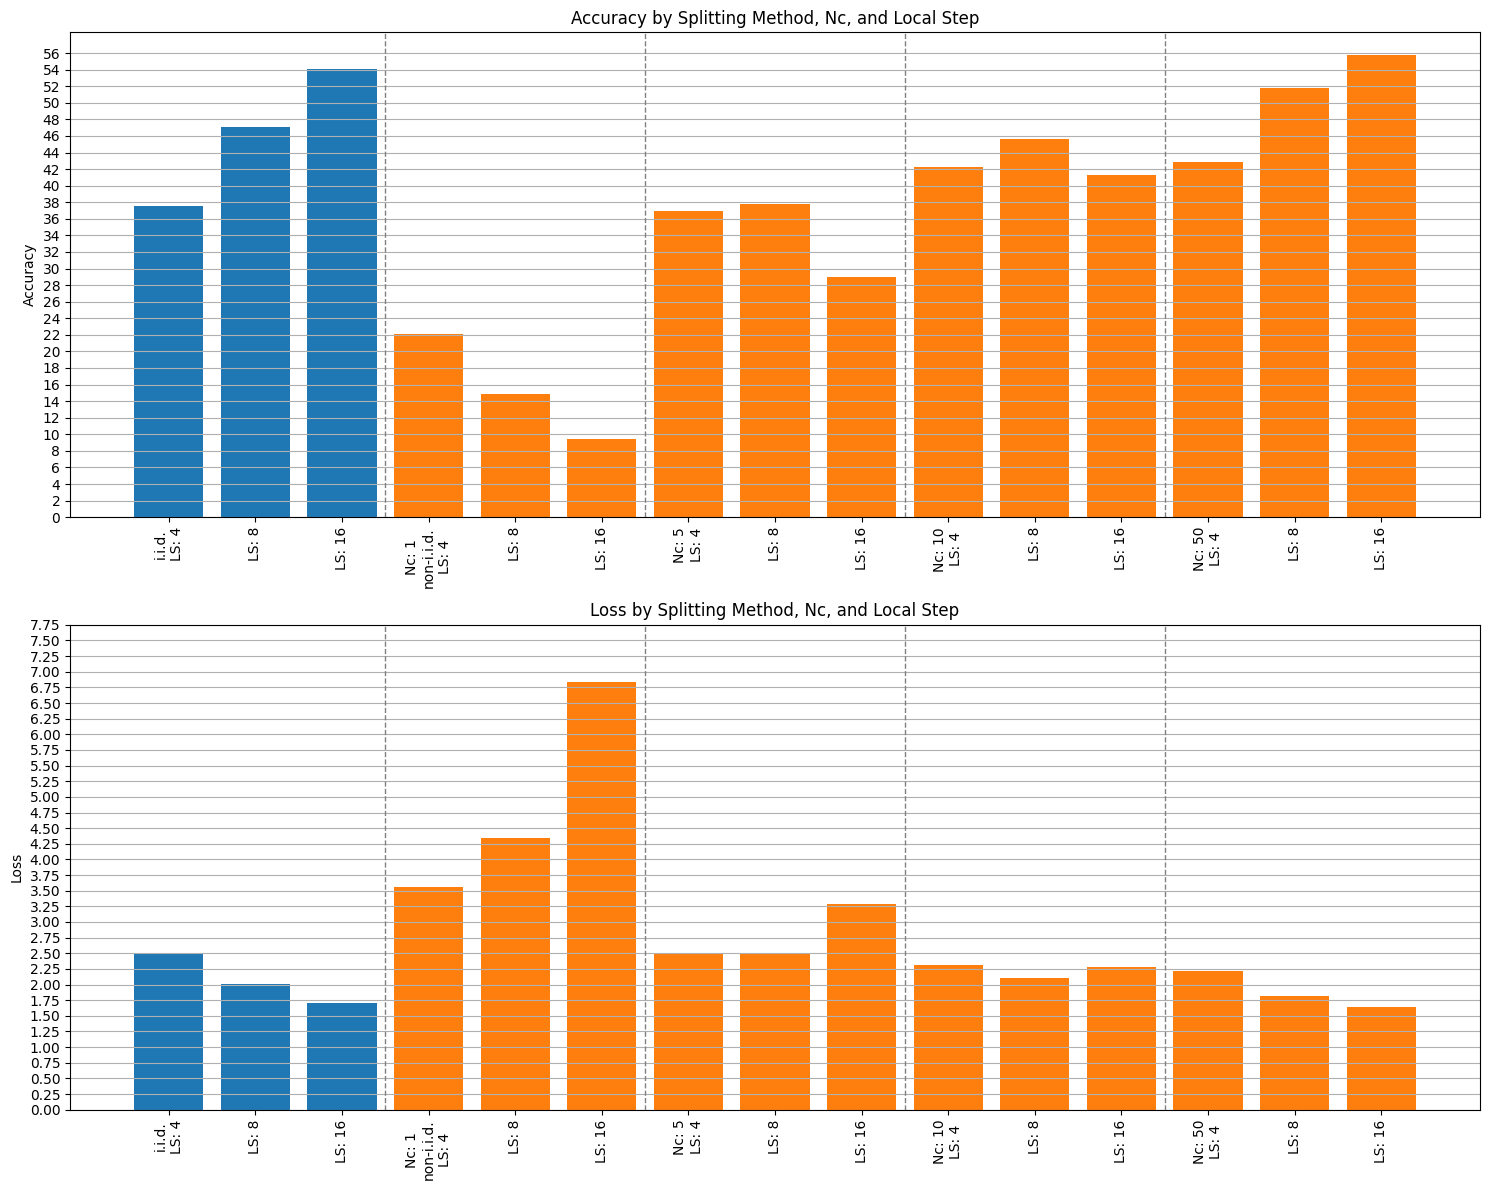

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

result_df = result_df[result_df['sparsity']== 0.5]
# Separate i.i.d. and non-i.i.d. data
iid_df = result_df[result_df['spliting_method'] == 'i.i.d.'].sort_values(by='local_step')
non_iid_df = result_df[result_df['spliting_method'] == 'non-i.i.d.'].sort_values(by=['Nc', 'local_step'])

# Combine the dataframes with i.i.d. first
result_df_sorted = pd.concat([iid_df, non_iid_df])

# Create a figure and a set of subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Get unique splitting methods for coloring
unique_splitting_methods = result_df_sorted['spliting_method'].unique()
color_map = dict(zip(unique_splitting_methods, sns.color_palette('tab10', len(unique_splitting_methods))))

# Plot Accuracy
ax1 = axes[0]
colors_accuracy = result_df_sorted['spliting_method'].map(color_map)
bars1 = ax1.bar(np.arange(len(result_df_sorted)), result_df_sorted['accuracy'], color=colors_accuracy)
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy by Splitting Method, Nc, and Local Step')
ax1.set_xticks([]) # Hide default x-axis ticks
ax1.set_yticks(np.arange(0, max(result_df_sorted['accuracy'])+1, 2)) # Hide default x-axis ticks

# Add custom x-axis labels and separators
label_positions = []
labels = []
separator_positions = []
current_split_method = None
current_nc = None

for i, row in result_df_sorted.reset_index().iterrows():
    label = f'LS: {int(row["local_step"])}'
    label_positions.append(i)
    labels.append(label)

    if row['spliting_method'] != current_split_method:
        if current_split_method is not None:
            separator_positions.append(i - 0.5) # Add separator before a new splitting method group
        current_split_method = row['spliting_method']
        labels[-1] = f'{row["spliting_method"]}\n' + labels[-1] # Add splitting method to label
        current_nc = None # Reset Nc for the new splitting method

    if row['spliting_method'] == 'non-i.i.d.' and row['Nc'] != current_nc:
        if current_nc is not None:
             separator_positions.append(i - 0.5) # Add separator before a new Nc group
        current_nc = row['Nc']
        labels[-1] = f'Nc: {int(row["Nc"])}\n' + labels[-1] # Add Nc to label


ax1.set_xticks(label_positions)
ax1.set_xticklabels(labels, rotation=90)
ax1.grid(axis='y')
for pos in separator_positions:
    ax1.axvline(x=pos, color='gray', linestyle='--', linewidth=1)


# Plot Loss
ax2 = axes[1]
colors_loss = result_df_sorted['spliting_method'].map(color_map)
bars2 = ax2.bar(np.arange(len(result_df_sorted)), result_df_sorted['loss'], color=colors_loss)
ax2.set_ylabel('Loss')
ax2.set_title('Loss by Splitting Method, Nc, and Local Step')
ax2.set_xticks([]) # Hide default x-axis ticks
ax2.set_yticks(np.arange(0, max(result_df_sorted['loss'])+1, 0.25)) # Hide default x-axis ticks

# Add custom x-axis labels and separators
label_positions = []
labels = []
separator_positions = []
current_split_method = None
current_nc = None

for i, row in result_df_sorted.reset_index().iterrows():
    label = f'LS: {int(row["local_step"])}'
    label_positions.append(i)
    labels.append(label)

    if row['spliting_method'] != current_split_method:
        if current_split_method is not None:
            separator_positions.append(i - 0.5) # Add separator before a new splitting method group
        current_split_method = row['spliting_method']
        labels[-1] = f'{row["spliting_method"]}\n' + labels[-1] # Add splitting method to label
        current_nc = None # Reset Nc for the new splitting method

    if row['spliting_method'] == 'non-i.i.d.' and row['Nc'] != current_nc:
        if current_nc is not None:

             separator_positions.append(i - 0.5) # Add separator before a new Nc group
        current_nc = row['Nc']
        labels[-1] = f'Nc: {int(row["Nc"])}\n' + labels[-1] # Add Nc to label
ax2.grid(axis='y')
ax2.set_xticks(label_positions)
ax2.set_xticklabels(labels, rotation=90)

for pos in separator_positions:
    ax2.axvline(x=pos, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
# plt.show()
plt.savefig("Accuracy and Loss by Splitting Method, Nc, and Local Step.pdf")

In [86]:
result_df = pd.read_csv("/content/drive/MyDrive/MLDL_FederatedLearning/csv/result_df.csv")

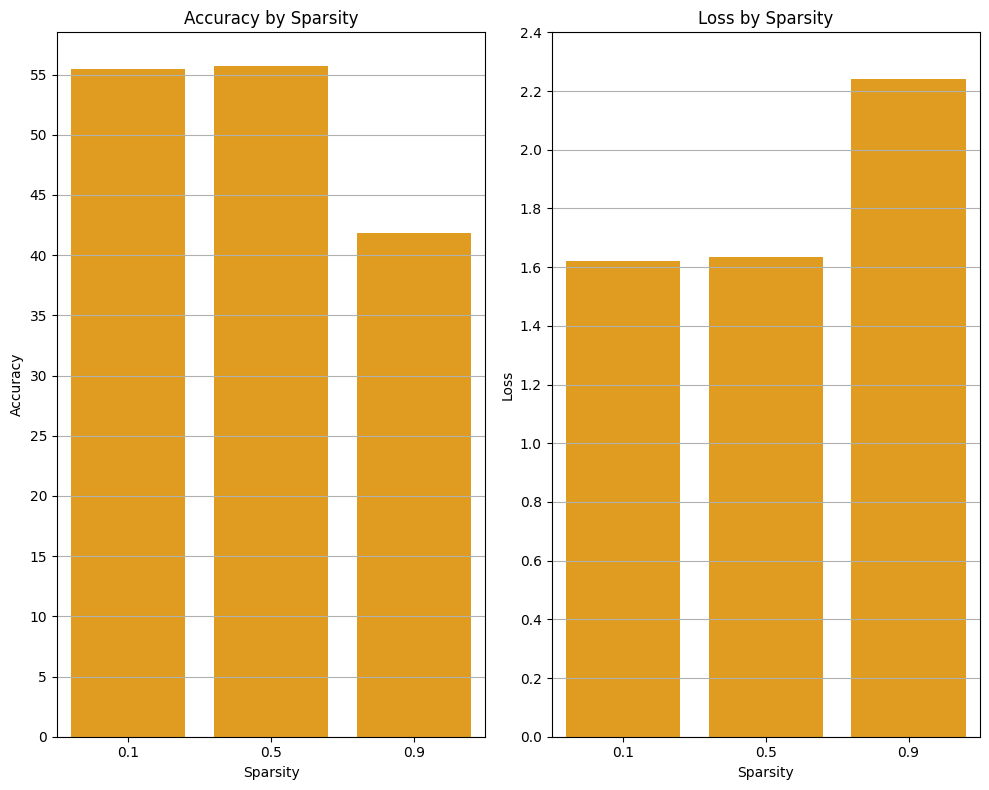

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the list of model names to filter by
target_models = ['83bd0a91-3c99-4fc9-b8e6-c13d3c6cdff0', 'afda943f-f16c-432a-ac3f-049d507f9ba3', 'a63ef45b-271e-4c54-8be8-c7c97b24e1ba']

# Filter the result_df for the target models and sort by sparsity
filtered_df = result_df[result_df['last_model_name'].isin(target_models)].sort_values(by='sparsity')

# Create a figure and a set of subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Bar chart for Accuracy
sns.barplot(x='sparsity', y='accuracy', data=filtered_df, ax=axes[0], color="orange")
axes[0].set_title('Accuracy by Sparsity')
axes[0].set_xlabel('Sparsity')
axes[0].set_ylabel('Accuracy')
axes[0].grid(axis='y')
axes[0].set_yticks(np.arange(0, max(filtered_df['accuracy'].values)+1, 5))
# Bar chart for Loss
sns.barplot(x='sparsity', y='loss', data=filtered_df, ax=axes[1], color="orange")
axes[1].set_title('Loss by Sparsity')
axes[1].set_xlabel('Sparsity')
axes[1].set_ylabel('Loss')
axes[1].grid(axis='y')
axes[1].set_yticks(np.arange(0, max(filtered_df['loss'].values)+0.2, 0.2))

plt.tight_layout()
plt.savefig("Accuracy and Loss by Sparsity.pdf")

# plt.show()

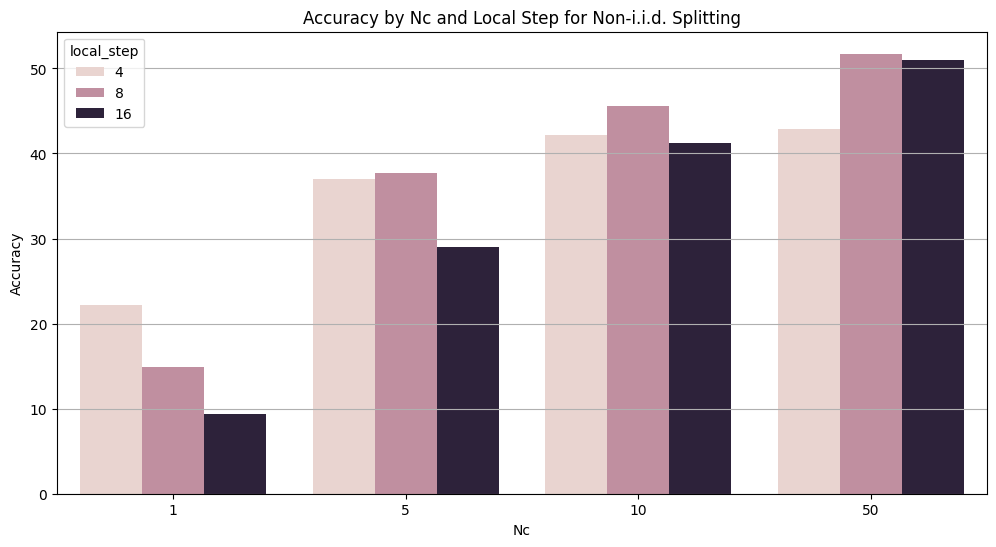

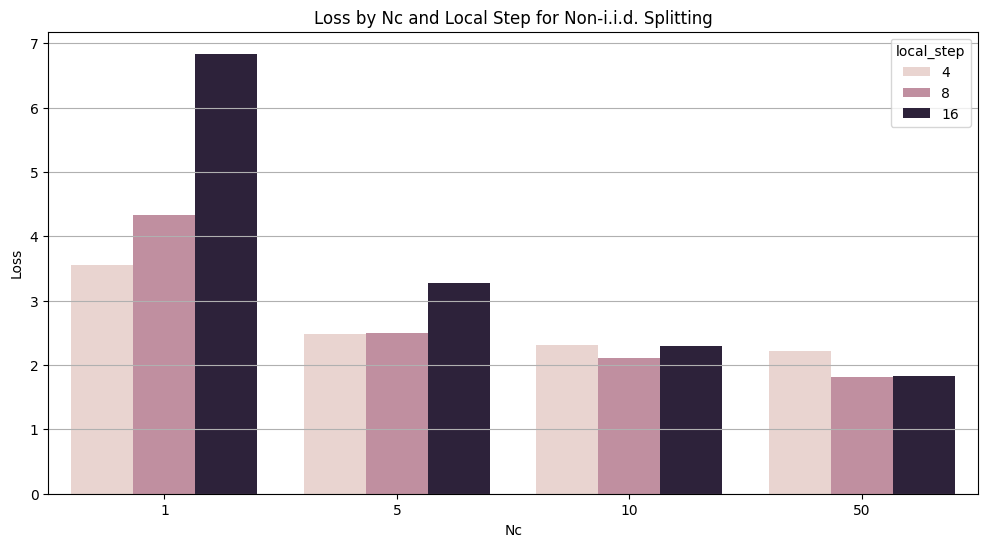

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for non-i.i.d. records
non_iid_df = result_df[result_df['spliting_method'] == 'non-i.i.d.']

# Create a grouped bar chart for Accuracy showing exact values
plt.figure(figsize=(12, 6))
sns.barplot(x='Nc', y='accuracy', hue='local_step', data=non_iid_df, errorbar=None) # errorbar=None to show individual bars

plt.title('Accuracy by Nc and Local Step for Non-i.i.d. Splitting')
plt.xlabel('Nc')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.show()

# Create a grouped bar chart for Loss showing exact values
plt.figure(figsize=(12, 6))
sns.barplot(x='Nc', y='loss', hue='local_step', data=non_iid_df, errorbar=None) # errorbar=None to show individual bars
plt.title('Loss by Nc and Local Step for Non-i.i.d. Splitting')
plt.xlabel('Nc')
plt.ylabel('Loss')
plt.grid(axis='y')
plt.show()